# Deep Learning Tutorial 2: Training

Welcome to the second deep learning tutorial!

In this notebook, we are going to apply recurrent neural networks to time series data in order to predict if a hard drive will fail the next day given a series of daily S.M.A.R.T. status observations.

Note that you can interrupt the training process at any time by clicking on *Kernel* and then *Interrupt*.

## Preparation

We will be using the [Keras](http://keras.io) framework that abstracts away a lot of the tedious details of deep learning. We will only use the [funcational API](https://keras.io/getting-started/functional-api-guide/) due to its expressive power.

In [1]:
import numpy as np
np.random.seed(42)

from keras.models import Model
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import *
from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import SVG

from callbacks import AUCHistory

Using Theano backend.


### Loading our data

Data has been saved in a file named *data.npz*. It can be loaded using *np.load* and then behaves similar to a Python dictionary, where they keys *records* and *labels* corresponds to a numpy array for our input data and our labels, respectively.

In [2]:
saved = np.load("data.npz")
data = saved["records"]
labels = saved["labels"]

The input data is a 3-dimensional array, where the first dimension corresponds to the number of instances, the second dimension to the number of time steps, and the third dimension to the number of features.

In [3]:
data.shape

(74574, 90, 15)

More specifically, 74574 is the number of drives in our data, 90 the number of observations per drive, and 15 features per record. Let us define some variables to make this more obvious.

In [4]:
n_drives = data.shape[0]
n_records = data.shape[1]
n_features = data.shape[2]

First, we define the input layer, which just takes in our data. It does not contain any logic other than defining the shape of our input. Since we use the functional API, this also means that all matrix shapes in the following layers will be inferred automatically.

In [5]:
input = Input(shape=(n_records, n_features), name="inputs")

Note that the first dimension, *n_drives*, is automatically inferred.

Now, the fun parts starts. We will add an LSTM layer that summarizes each drive by performing the same computation on vectors of size n_features for each n_records.

Remember the unfolding in time computation graph for an RNN

![image](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/rnn.jpg)

where $x_t$ are observations for a particular drive, e.g. $x_1$ is the first observation and $x_2$ is the second observation. In our case, we are only interested in the last output $o_t$ where $t = \text{n_records}$. The output of this LSTM will be a vector of size 10. In other words, the LSTM has 10 neurons in the output layer.

In [7]:
x = LSTM(10)(input)

We're almost done! Let's wire up the 10 output neurons of the LSTM to just a single output neuron using a [Dense](https://keras.io/layers/core/#dense) layer. A Dense layer is just your regular fully connected NN layer.

The output of the dense layer will be $\sigma(x)$, with $\sigma(x) = \frac{1}{1 + exp(-z)}$ where $z$ is just a linear combination of the LSTM outputs, i.e. $\sum\limits w_j x_j$ of the previous layer, where $w_j$ are the learnt weights  for the connection from the LSTM to the Dense layer and $x_j$ is the output of the LSTM. Conveniently, the output of $\sigma(x)$ lies between $0$ and $1$ and matches our target well.

In [8]:
output = Dense(1, activation='sigmoid', name='output')(x)

Let's wrap up the input and output of our Model.

In [9]:
model = Model(input=input, output=output)

Now, we will compile our model. Here, we specify two parameters:

- optimizer: an optimizer does all the work for us. Given the input and the computed errors, it decides which direction to take. There are quite a few [optimizers available in Keras](https://keras.io/optimizers/).
- loss: the loss or objective function tells the model how well we are doing on our data. In our case, this is simply binary crossentropy, but in other cases this may be e.g. mean squared error. Note that this function needs to be differentiable because during training we need to be able to compute the weight updates. Hence, we cannot optimize for e.g. ROCAUC directly.

In [10]:
model.compile(optimizer=Nadam(), loss="binary_crossentropy")

Let's print out a nice plot of our model.

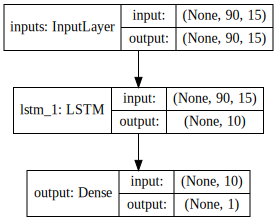

In [11]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Note that *None* simply means that the model does not really care how many instances we input.

## Let's train!

We train using a mini-batch size of 20 instances at a time. This speeds up things, because a mini-batch can be computed in parallel on a GPU. We train for eight epochs, i.e. we go over our training set three times.

Conveniently, Keras will create a hold-out validation set automatically for us when giving the *validation_split* parameter. Let's set it to 20% of our data. **Please leave *verbose* at 2** in the following call, otherwise your notebook may freeze.

In [12]:
model.fit(data, labels, verbose=2, nb_epoch=8, batch_size=20, validation_split=0.2, callbacks=[AUCHistory()])

Train on 59659 samples, validate on 14915 samples
Epoch 1/8

Epoch validation AUC: 0.599408961409

24s - loss: 0.0411 - val_loss: 0.0277
Epoch 2/8

Epoch validation AUC: 0.835174825175

24s - loss: 0.0290 - val_loss: 0.0220
Epoch 3/8

Epoch validation AUC: 0.835212639213

23s - loss: 0.0280 - val_loss: 0.0214
Epoch 4/8

Epoch validation AUC: 0.842813778814

24s - loss: 0.0279 - val_loss: 0.0216
Epoch 5/8

Epoch validation AUC: 0.835188293188

23s - loss: 0.0279 - val_loss: 0.0211
Epoch 6/8

Epoch validation AUC: 0.835188293188

23s - loss: 0.0279 - val_loss: 0.0213
Epoch 7/8

Epoch validation AUC: 0.835188293188

23s - loss: 0.0279 - val_loss: 0.0212
Epoch 8/8

Epoch validation AUC: 0.842765086765

23s - loss: 0.0279 - val_loss: 0.0211


That wasn't so bad. You can see that our network converges after the second epoch and neither our training loss nor the AUC improve anymore. 

## Task 1: Increase the number of neurons

Maybe the model is simply to small to accomodate patterns in our data? Let's try to increase our neurons to 50.

**Your task** is to:

- Mark this chunk and select *Cell* and then *Run All Above*
- Increase the number of neurons to 20

In [13]:
input = Input(shape=(n_records, n_features), name="inputs")
x = input
x = LSTM(20)(x)
output = Dense(1, activation='sigmoid', name='output')(x)
model1 = Model(input=input, output=output)
model1.compile(optimizer=Nadam(), loss="binary_crossentropy")

In [14]:
model1.fit(data, labels, verbose=2, nb_epoch=8, batch_size=20, validation_split=0.2, callbacks=[AUCHistory()])

Train on 59659 samples, validate on 14915 samples
Epoch 1/8

Epoch validation AUC: 0.919364413364

36s - loss: 0.0391 - val_loss: 0.0236
Epoch 2/8

Epoch validation AUC: 0.920628334628

34s - loss: 0.0216 - val_loss: 0.0227
Epoch 3/8

Epoch validation AUC: 0.920628334628

38s - loss: 0.0209 - val_loss: 0.0259
Epoch 4/8

Epoch validation AUC: 0.921917637918

40s - loss: 0.0208 - val_loss: 0.0220
Epoch 5/8

Epoch validation AUC: 0.920603470603

39s - loss: 0.0207 - val_loss: 0.0225
Epoch 6/8

Epoch validation AUC: 0.920603470603

36s - loss: 0.0207 - val_loss: 0.0238
Epoch 7/8

Epoch validation AUC: 0.920603470603

41s - loss: 0.0206 - val_loss: 0.0240
Epoch 8/8

Epoch validation AUC: 0.917975135975

49s - loss: 0.0206 - val_loss: 0.0237


This is much better! If you want, you can try a different number of neurons.

## Task 2: Add another layer

Let's make our model deeper! This is deep learning after all. Note that our network is already deep in time, i.e. we take into consideration 90 time steps. But we can also make it deeper vertically.

Your task is to

- stack another LSTM layer on top of the layer we already have.

At each time step, the first LSTM will feed into the second LSTM. This is called stacking.

Note that for this, you have to set *return_sequences=True* in the first LSTM. Do you understand why this is required?

In [15]:
input = Input(shape=(n_records, n_features), name="inputs")
x = input

### Your code goes here:
x = LSTM(30, return_sequences=True)(x)
x = LSTM(30)(x)
##

output = Dense(1, activation='sigmoid', name='output')(x)
model2 = Model(input=input, output=output)
model2.compile(optimizer=Nadam(), loss="binary_crossentropy")

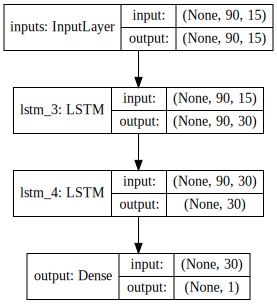

In [16]:
SVG(model_to_dot(model2, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
model2.fit(data, labels, verbose=2, nb_epoch=8, batch_size=20, validation_split=0.2, callbacks=[AUCHistory()])

Train on 59659 samples, validate on 14915 samples
Epoch 1/8

Epoch validation AUC: 0.955261849262

132s - loss: 0.0262 - val_loss: 0.0294
Epoch 2/8

Epoch validation AUC: 0.955068117068

128s - loss: 0.0207 - val_loss: 0.0202
Epoch 3/8

Epoch validation AUC: 0.908868686869

129s - loss: 0.0194 - val_loss: 0.0250
Epoch 4/8

Epoch validation AUC: 0.908648018648

126s - loss: 0.0184 - val_loss: 0.0283
Epoch 5/8

Epoch validation AUC: 0.965678839679

129s - loss: 0.0185 - val_loss: 0.0211
Epoch 6/8

Epoch validation AUC: 0.940064750065

124s - loss: 0.0183 - val_loss: 0.0275
Epoch 7/8

Epoch validation AUC: 0.94785962186

119s - loss: 0.0182 - val_loss: 0.0230
Epoch 8/8

Epoch validation AUC: 0.959258741259

130s - loss: 0.0182 - val_loss: 0.0230


## Task 3: Change the architecture

This task will be a bit more challenging. We are going to use an additional attribute: the disk's model. However, because this attribute is constant in a disks's time series, we will not add it to LSTM that summarizes the time series.

Instead, we will *merge* the $n$-dimensional vector output of the LSTM with a $m$-dimensional vector, where merging means concatenating the two vectors into a vector of dimensionality $n+m$.

Conveniently, we have already encoded the disk's model as a one-hot vector, i.e. the columns in the following matrix correspond to unique disk models and the rows to individual disks.

In [18]:
models = saved["models"]

In [19]:
models.shape

(74574, 63)

In this task, you have to do the following:

- Create a second Input with shape `(number_of_models, )`. Note that you do not need masking here because we are at this step no longer working with a time series with missing observations.
- Introduce a [Merge](https://keras.io/getting-started/sequential-model-guide/#the-merge-layer) layer that merges `[x, your_new_input]`
- Modify the `Model` instantiation to take two inputs simultaneously, similar to what you have done in the previous step.

In [20]:
input = Input(shape=(n_records, n_features), name="inputs")
input2 = Input(shape=(models.shape[1], ))

x = input
x = LSTM(20, return_sequences=True)(x)
x = LSTM(20)(x)

x2 = input2

x = merge([x, x2], mode="concat")

output = Dense(1, activation='sigmoid', name='output')(x)
model3 = Model(input=[input, input2], output=output)
model3.compile(optimizer=Nadam(), loss="binary_crossentropy")

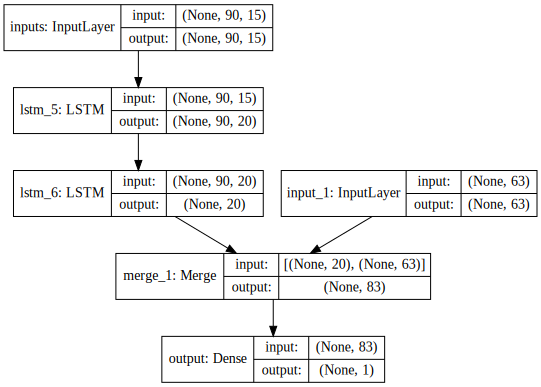

In [21]:
SVG(model_to_dot(model3, show_shapes=True).create(prog='dot', format='svg'))

In [22]:
model3.fit([data, models], labels, verbose=2, nb_epoch=10, batch_size=20, validation_split=0.2, callbacks=[AUCHistory()])

Train on 59659 samples, validate on 14915 samples
Epoch 1/10

Epoch validation AUC: 0.973593369593

91s - loss: 0.0265 - val_loss: 0.0367
Epoch 2/10

Epoch validation AUC: 0.970472934473

75s - loss: 0.0134 - val_loss: 0.0491
Epoch 3/10

Epoch validation AUC: 0.970769230769

75s - loss: 0.0118 - val_loss: 0.0448
Epoch 4/10

Epoch validation AUC: 0.973865837866

75s - loss: 0.0120 - val_loss: 0.0557
Epoch 5/10

Epoch validation AUC: 0.977092981093

76s - loss: 0.0109 - val_loss: 0.0585
Epoch 6/10

Epoch validation AUC: 0.976356902357

77s - loss: 0.0108 - val_loss: 0.0452
Epoch 7/10

Epoch validation AUC: 0.973822325822

80s - loss: 0.0108 - val_loss: 0.0573
Epoch 8/10

Epoch validation AUC: 0.973641025641

78s - loss: 0.0105 - val_loss: 0.0591
Epoch 9/10

Epoch validation AUC: 0.97258016058

81s - loss: 0.0099 - val_loss: 0.0949
Epoch 10/10

Epoch validation AUC: 0.964224812225

79s - loss: 0.0098 - val_loss: 0.0921


It's still getting better! This concludes the second deep learning tutorial.

If you still have some free time, you are welcome to experiment further with our architecture. Things you may want to try:

- Use GRU instead of LSTM units
- Introduce regularization such as dropout